##GANs for Synthetic Data Generation

We implement a Generative Adversarial Network (GAN) in the Keras functional API. In this module we will pay attention to:

- Implementing the GAN architecture in Keras.
- Training our model.
- Using our model to generate synthetic data.

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  9 02:29:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    47W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We import required libraries.

In [2]:
# from keras.datasets.mnist import load_data
from keras.datasets.cifar10 import load_data
from keras import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Input,Dense,Conv2D,Flatten,Dropout,LeakyReLU,Reshape,Conv2DTranspose
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping
from statistics import mean

from matplotlib import pyplot

import numpy as np
import numpy.random as rng


As in the denoising auto-encoder module, we will be working with the MNIST data. These are 28x28 greyscale images of handwritten digits (0-9). The classes are the digit. 

This data is included in Keras.datasets library, so it is easy to load. We will expand the image dimension so that we have a single channel (as it is greyscale we have only one channel), and normalize the pixel values to real numbers between 0 and 1.

We will only work with the training data, and so will create a function that pre-processes and returns that. If you want to look at the data, examine the code in module 2.4, as this provides functions for viewing the MNIST images with their class labels.

In [3]:
def get_data ():
  # load the images into memory
  (trainX, trainy), (testX, testy) = load_data()
  # We will only really work with the trainX data.
  # Let's expand it to add channel dimension
  # X = np.expand_dims(trainX, axis=-1)
  X = trainX
  # Convert from unsigned ints to floats and scale to between 0 and 1.
  X = X.astype('float32')
  X = X / 255.0
  return X


# # Load images
# (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# # Normalize pixel values to be between 0 and 1
# train_images, test_images = train_images / 255.0, test_images / 255.0

# # Make versions of the labels that are one-hot vectors
# train_labels_array=np_utils.to_categorical(train_labels, 10)
# test_labels_array=np_utils.to_categorical(test_labels, 10)

# # Make vector of classnames
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#                'dog', 'frog', 'horse', 'ship', 'truck']

We call our get data function.

In [4]:
X=get_data()

We want our discriminator to train on batches of real and fake images, learning to distinguish between the two. So we need a function to grab a set of real images from our MNIST image data.

In [5]:
# select real samples
def select_real_images(dataset, n_samples):
    # choose random instances
    indices = rng.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[indices]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

Now let us define a function to create our discriminator model. We will also compile it within the function, so if you want to play around with the optimizer change the code in here.

In [6]:
def get_discriminator(in_shape=(32,32,3)):
  # Define Model
  # This is a basic binary classification CNN
  inputs=Input(in_shape)
  
  conv1=Conv2D(128, 3, strides=2, padding='same')(inputs)
  leak1=LeakyReLU(alpha=.2)(conv1)
  drop1=Dropout(.4)(leak1)
  
  conv2=Conv2D(64, 3, strides=2, padding='same')(drop1)
  leak2=LeakyReLU(alpha=.2)(conv2)
  drop2=Dropout(.4)(leak2)
  
  flat=Flatten()(drop2)
  outputs=Dense(1,activation='sigmoid')(flat)
  
  # Create Model
  model=Model(inputs=inputs,outputs=outputs)
  
  # Compile model
  opt = Adam(lr=0.001, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

If you wish, run the following code block to create an instance of the discriminator model in order to view a summary.

Note we will create the discriminator instance we use for the problem in a later code block.

In [7]:
# Get the discriminator
discriminator = get_discriminator()
# View a summary of the discriminator
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          73792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0     

In [8]:
def get_generator(noise_dim=100):
    # Define the generator model
    inputs=Input((noise_dim,))
    
    # Create a basis for 8x8 image
    # We are using the noise to generate 128 high level 'feature maps' in a 7x7 space
    n = 128 * 8 * 8
    dense = Dense(n)(inputs)
    leak1 = LeakyReLU(alpha=0.2)(dense)
    reshape = Reshape((8, 8, 128))(leak1)
    
    # Now we extract lower level features...
    # Upsample to 16x16
    conv_tran1 = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(reshape)
    leak2=LeakyReLU(alpha=0.2)(conv_tran1)
    
    # Now we extract even lower level features...
    # Upsample to 32x32
    conv_tran2 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(leak2)
    leak3 = LeakyReLU(alpha=0.2)(conv_tran2)
    
    # Finally we put togeather our pixel values for the synthetic image
    outputs = Conv2D(3, (8,8), activation='sigmoid', padding='same')(leak3)
    
    # Create the model and return it
    model=Model(inputs=inputs,outputs=outputs)
    return model

If you wish, run the following code block to create an instance of the generator model in order to view a summary. You can change the dimension of the noise vector if you like.

Note we will create the generator instance we use for the problem in a later code block.

In [9]:
# Specify the dimension of the noise vector
noise_dim = 300
# Get the generator model
generator = get_generator(noise_dim)
# Summarize the model
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              2465792   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        7379

Obviously we want to generate this noise from something simple so that we can sample from the same distribution later. So we use simple independent Gaussian noise.

We create a function that will generate as many of these noise vectors as we wish.

In [10]:
# Generate independent Gaussian noise as input for the generator
def generate_input_noise(noise_dim, num_vectors):
    # Generate independent Gaussian noise
    noise_input = rng.standard_normal(noise_dim * num_vectors)
    # Reshape into a 2d array
    noise_input = noise_input.reshape(num_vectors, noise_dim)
    return noise_input

Now we create a function to generate fake images from the noise vectors using the generator. We will also get this function to return labels indicating that the images are fake (we represent this by 0).

In [11]:
# Generate n fake images using the generator
def generate_fake_images(generator, noise_dim, n_images):
    # Generate noise vectors
    noise = generate_input_noise(noise_dim, n_images)
    # Use generator to create fake images from noise vectors
    fakes = generator.predict(noise)
    # create 'fake' class labels (0)
    labels = np.zeros((n_images, 1))
    return fakes, labels

Let's also create a function that plot's fake images created by the generator so we look at them.

In [12]:
# Plot fake images created by generator from random noise
def plot_generated_images(generator,noise_dim=100,n_images=25):
    # Create the fake images (we don't need the labels here)
    X, _ = generate_fake_images(generator, noise_dim, n_images)
    # Plot the fake images
    for i in range(n_images):
        pyplot.subplot(5, 5, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, :])
    pyplot.show()

Now we will create a function to make our GAN. This will involve putting the discriminator and generator together into a single model. We will also want to be able to treat them as individual models as well, so we will return (1) the discriminator, (2) the generator, and (3) the combined GAN.

Note that we will make the weights in the discriminator non-trainable in the combined GAN model. This means that when we train the GAN we are actually only optimizing the weights in the generator. I discuss this further after we define the train function below.

Once again, we will compile the model in the function. This is the optimizer that will be used for training the generator (because of the above). If you want to play around with the optimizer change the code inside the function.

In [13]:
# Create the discriminator, generator and GAN networks.
# Compile networks requiring compilation within function.
def get_gan_models(noise_dim=100):
    # Create the discriminator (compiled internally)
    discriminator = get_discriminator()
    # Create the generator
    generator = get_generator(noise_dim)
    
    # Make weights in the discriminator not trainable
    discriminator.trainable = False
    
    # Make GAN
    inputs = Input((noise_dim,))
    gan = Model(inputs,discriminator(generator(inputs)))
    
    # Compile model
    opt = Adam(lr=0.001, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    
    return discriminator,generator,gan

Now let's finally get our networks. If you want to change the noise dimension we work with in the problem, change the value here.

In [14]:
noise_dim=300
discriminator,generator,gan=get_gan_models(noise_dim)

We are going to code a manual implementation of the training loop. This is so we can implement appropriate training for the discriminater and generator.

Note we do not use validation data, and such data makes little sense in this context.

In [15]:
#Iter 3
# Train the generator and discriminator
def train(
    gan, 
    generator,
    discriminator,
    dataset, 
    noise_dim=300, 
    epochs=500, 
    batch_size=1024
):
    # We keep the amount of work done per 'epoch' matching
    # the dataset size, though in reality this is quite arbitrary.
    batches_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # Iterate through desired number of epochs
    for i in range(epochs):
      # Iterate through batches
      d_loss_list = []
      g_loss_list = []
      for j in range(batches_per_epoch):
        # Train the discriminator            
        # Get randomly selected real images
        X_real, Y_real = select_real_images(dataset, half_batch)
        # Generate fake images
        X_fake, Y_fake = generate_fake_images(generator, noise_dim, half_batch)
        # Create training set for the discriminator
        X, Y = np.vstack((X_real, X_fake)), np.vstack((Y_real, Y_fake))
        # Update discriminator model weights
        d_loss, _ = discriminator.train_on_batch(X, Y)
        d_loss_list.append(d_loss) 

        # Train the generator
        # Prepare input noise
        X_gan = generate_input_noise(noise_dim, batch_size)
        # Create inverted labels for the fake samples
        # This is because the GAN/generator is trying to get the discriminator
        # to classify these fake images as real.
        Y_gan = np.ones((batch_size, 1))
        # Update the generator weights via the discriminator's error
        # Remember the discriminator's weights are fixed in the GAN,
        # so these will not be adjusted.
        g_loss = gan.train_on_batch(X_gan, Y_gan)
        g_loss_list.append(g_loss)


        # Give information about loss on this batch
        # print("Epoch: {} Batch: {}/{} Disc. Loss: {:06.5f} Gen. Loss: {:06.5f}".format(i+1, j+1,batches_per_epoch, d_loss, g_loss))
        # print("Epoch: {} Batch: {}/{}".format(i+1, j+1,batches_per_epoch))


      # Epoch performance
      print('Epoch: {}, Discriminator loss mean:{:06.5f}, Generator loss mean:{:06.5f}'.format(i+1,mean(d_loss_list),mean(g_loss_list)))
      if not i%10:
        plot_generated_images(generator,300,25)
        # gpu_info = !nvidia-smi
        # gpu_info = '\n'.join(gpu_info)
        # print(gpu_info)

Epoch: 1, Discriminator loss mean:0.71605, Generator loss mean:0.78950


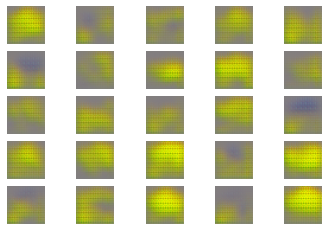

Epoch: 2, Discriminator loss mean:0.69423, Generator loss mean:0.73970
Epoch: 3, Discriminator loss mean:0.70354, Generator loss mean:0.80794
Epoch: 4, Discriminator loss mean:0.68954, Generator loss mean:0.84836
Epoch: 5, Discriminator loss mean:0.69058, Generator loss mean:0.78012
Epoch: 6, Discriminator loss mean:0.69908, Generator loss mean:0.76963
Epoch: 7, Discriminator loss mean:0.68838, Generator loss mean:0.75821
Epoch: 8, Discriminator loss mean:0.69217, Generator loss mean:0.77713
Epoch: 9, Discriminator loss mean:0.70076, Generator loss mean:0.78288
Epoch: 10, Discriminator loss mean:0.70209, Generator loss mean:0.76044
Epoch: 11, Discriminator loss mean:0.70006, Generator loss mean:0.73786


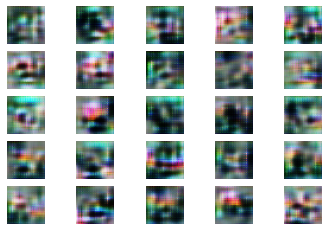

Epoch: 12, Discriminator loss mean:0.69391, Generator loss mean:0.72179
Epoch: 13, Discriminator loss mean:0.69338, Generator loss mean:0.73498
Epoch: 14, Discriminator loss mean:0.69557, Generator loss mean:0.73581
Epoch: 15, Discriminator loss mean:0.69725, Generator loss mean:0.71823
Epoch: 16, Discriminator loss mean:0.69642, Generator loss mean:0.73132
Epoch: 17, Discriminator loss mean:0.69452, Generator loss mean:0.70150
Epoch: 18, Discriminator loss mean:0.69271, Generator loss mean:0.71716
Epoch: 19, Discriminator loss mean:0.69511, Generator loss mean:0.70854
Epoch: 20, Discriminator loss mean:0.69585, Generator loss mean:0.73168
Epoch: 21, Discriminator loss mean:0.69917, Generator loss mean:0.72330


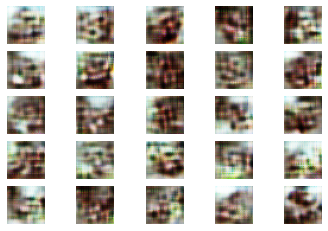

Epoch: 22, Discriminator loss mean:0.69589, Generator loss mean:0.71062
Epoch: 23, Discriminator loss mean:0.69438, Generator loss mean:0.73072
Epoch: 24, Discriminator loss mean:0.69496, Generator loss mean:0.71488
Epoch: 25, Discriminator loss mean:0.69757, Generator loss mean:0.72152
Epoch: 26, Discriminator loss mean:0.69977, Generator loss mean:0.72105
Epoch: 27, Discriminator loss mean:0.69665, Generator loss mean:0.72240
Epoch: 28, Discriminator loss mean:0.69359, Generator loss mean:0.71436
Epoch: 29, Discriminator loss mean:0.69741, Generator loss mean:0.71250
Epoch: 30, Discriminator loss mean:0.69410, Generator loss mean:0.71935
Epoch: 31, Discriminator loss mean:0.69554, Generator loss mean:0.71337


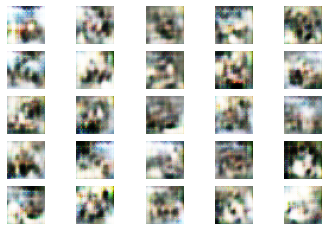

Epoch: 32, Discriminator loss mean:0.69653, Generator loss mean:0.72185
Epoch: 33, Discriminator loss mean:0.69704, Generator loss mean:0.70663
Epoch: 34, Discriminator loss mean:0.69477, Generator loss mean:0.71518
Epoch: 35, Discriminator loss mean:0.69476, Generator loss mean:0.71960
Epoch: 36, Discriminator loss mean:0.69486, Generator loss mean:0.71199
Epoch: 37, Discriminator loss mean:0.69492, Generator loss mean:0.71352
Epoch: 38, Discriminator loss mean:0.69546, Generator loss mean:0.70514
Epoch: 39, Discriminator loss mean:0.69575, Generator loss mean:0.70566
Epoch: 40, Discriminator loss mean:0.69532, Generator loss mean:0.71554
Epoch: 41, Discriminator loss mean:0.69445, Generator loss mean:0.70127


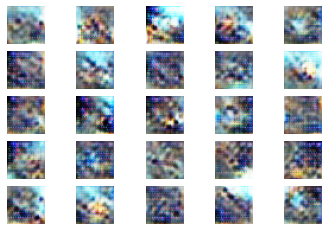

Epoch: 42, Discriminator loss mean:0.69481, Generator loss mean:0.71283
Epoch: 43, Discriminator loss mean:0.69301, Generator loss mean:0.70198
Epoch: 44, Discriminator loss mean:0.69588, Generator loss mean:0.69939
Epoch: 45, Discriminator loss mean:0.69421, Generator loss mean:0.70786
Epoch: 46, Discriminator loss mean:0.69606, Generator loss mean:0.70697
Epoch: 47, Discriminator loss mean:0.69439, Generator loss mean:0.70906
Epoch: 48, Discriminator loss mean:0.69538, Generator loss mean:0.70587
Epoch: 49, Discriminator loss mean:0.69516, Generator loss mean:0.71427
Epoch: 50, Discriminator loss mean:0.69599, Generator loss mean:0.70321
Epoch: 51, Discriminator loss mean:0.69452, Generator loss mean:0.70937


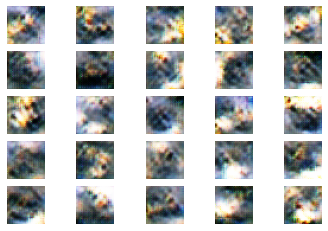

Epoch: 52, Discriminator loss mean:0.69333, Generator loss mean:0.69746
Epoch: 53, Discriminator loss mean:0.69457, Generator loss mean:0.70696
Epoch: 54, Discriminator loss mean:0.69423, Generator loss mean:0.70753
Epoch: 55, Discriminator loss mean:0.69412, Generator loss mean:0.70507
Epoch: 56, Discriminator loss mean:0.69469, Generator loss mean:0.71237
Epoch: 57, Discriminator loss mean:0.69581, Generator loss mean:0.71428
Epoch: 58, Discriminator loss mean:0.69636, Generator loss mean:0.71638
Epoch: 59, Discriminator loss mean:0.69550, Generator loss mean:0.70793
Epoch: 60, Discriminator loss mean:0.69362, Generator loss mean:0.70724
Epoch: 61, Discriminator loss mean:0.69610, Generator loss mean:0.70652


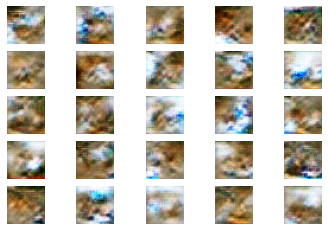

Epoch: 62, Discriminator loss mean:0.69494, Generator loss mean:0.70604
Epoch: 63, Discriminator loss mean:0.69426, Generator loss mean:0.70952
Epoch: 64, Discriminator loss mean:0.69642, Generator loss mean:0.71130
Epoch: 65, Discriminator loss mean:0.69459, Generator loss mean:0.70720
Epoch: 66, Discriminator loss mean:0.69739, Generator loss mean:0.71635
Epoch: 67, Discriminator loss mean:0.69568, Generator loss mean:0.70458
Epoch: 68, Discriminator loss mean:0.69595, Generator loss mean:0.71288
Epoch: 69, Discriminator loss mean:0.69401, Generator loss mean:0.71142
Epoch: 70, Discriminator loss mean:0.69464, Generator loss mean:0.71155
Epoch: 71, Discriminator loss mean:0.69559, Generator loss mean:0.71156


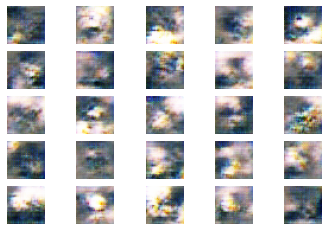

Epoch: 72, Discriminator loss mean:0.69519, Generator loss mean:0.70718
Epoch: 73, Discriminator loss mean:0.69376, Generator loss mean:0.71092
Epoch: 74, Discriminator loss mean:0.69514, Generator loss mean:0.70717
Epoch: 75, Discriminator loss mean:0.69522, Generator loss mean:0.70379
Epoch: 76, Discriminator loss mean:0.69518, Generator loss mean:0.70948
Epoch: 77, Discriminator loss mean:0.69527, Generator loss mean:0.70862
Epoch: 78, Discriminator loss mean:0.69374, Generator loss mean:0.70904
Epoch: 79, Discriminator loss mean:0.69796, Generator loss mean:0.70910
Epoch: 80, Discriminator loss mean:0.69498, Generator loss mean:0.71072
Epoch: 81, Discriminator loss mean:0.69475, Generator loss mean:0.71218


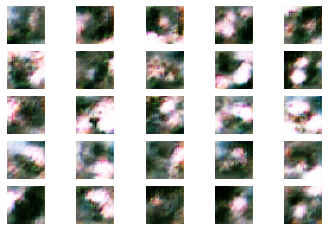

Epoch: 82, Discriminator loss mean:0.69500, Generator loss mean:0.70860
Epoch: 83, Discriminator loss mean:0.69574, Generator loss mean:0.70822
Epoch: 84, Discriminator loss mean:0.69795, Generator loss mean:0.71961
Epoch: 85, Discriminator loss mean:0.69530, Generator loss mean:0.70828
Epoch: 86, Discriminator loss mean:0.69656, Generator loss mean:0.70443
Epoch: 87, Discriminator loss mean:0.69633, Generator loss mean:0.70666
Epoch: 88, Discriminator loss mean:0.69399, Generator loss mean:0.70829
Epoch: 89, Discriminator loss mean:0.69931, Generator loss mean:0.71547
Epoch: 90, Discriminator loss mean:0.69599, Generator loss mean:0.71514
Epoch: 91, Discriminator loss mean:0.69607, Generator loss mean:0.70392


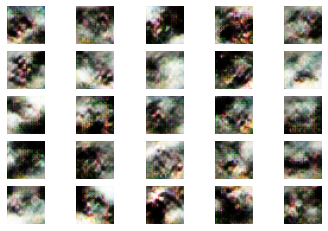

Epoch: 92, Discriminator loss mean:0.69464, Generator loss mean:0.70725
Epoch: 93, Discriminator loss mean:0.69474, Generator loss mean:0.70118
Epoch: 94, Discriminator loss mean:0.69699, Generator loss mean:0.70917
Epoch: 95, Discriminator loss mean:0.69567, Generator loss mean:0.70284
Epoch: 96, Discriminator loss mean:0.69420, Generator loss mean:0.70358
Epoch: 97, Discriminator loss mean:0.69459, Generator loss mean:0.70331
Epoch: 98, Discriminator loss mean:0.69480, Generator loss mean:0.70522
Epoch: 99, Discriminator loss mean:0.69459, Generator loss mean:0.71449
Epoch: 100, Discriminator loss mean:0.69672, Generator loss mean:0.70646
Epoch: 101, Discriminator loss mean:0.69531, Generator loss mean:0.70470


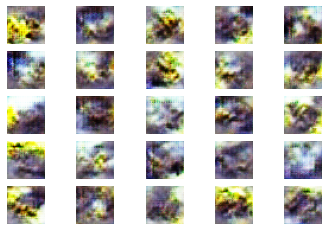

Epoch: 102, Discriminator loss mean:0.69468, Generator loss mean:0.70439
Epoch: 103, Discriminator loss mean:0.69442, Generator loss mean:0.70867
Epoch: 104, Discriminator loss mean:0.69596, Generator loss mean:0.71065
Epoch: 105, Discriminator loss mean:0.69618, Generator loss mean:0.70959
Epoch: 106, Discriminator loss mean:0.69681, Generator loss mean:0.70908
Epoch: 107, Discriminator loss mean:0.69438, Generator loss mean:0.70658
Epoch: 108, Discriminator loss mean:0.69449, Generator loss mean:0.70728
Epoch: 109, Discriminator loss mean:0.69668, Generator loss mean:0.71001
Epoch: 110, Discriminator loss mean:0.69542, Generator loss mean:0.70569
Epoch: 111, Discriminator loss mean:0.69570, Generator loss mean:0.71148


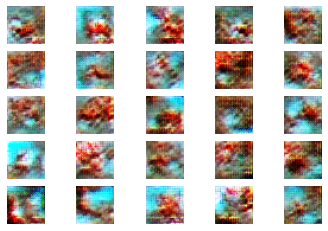

Epoch: 112, Discriminator loss mean:0.69454, Generator loss mean:0.70788
Epoch: 113, Discriminator loss mean:0.69568, Generator loss mean:0.71431
Epoch: 114, Discriminator loss mean:0.69613, Generator loss mean:0.70899
Epoch: 115, Discriminator loss mean:0.69852, Generator loss mean:0.72099
Epoch: 116, Discriminator loss mean:0.69805, Generator loss mean:0.71606
Epoch: 117, Discriminator loss mean:0.69433, Generator loss mean:0.70668
Epoch: 118, Discriminator loss mean:0.69431, Generator loss mean:0.70542
Epoch: 119, Discriminator loss mean:0.69557, Generator loss mean:0.71668
Epoch: 120, Discriminator loss mean:0.69603, Generator loss mean:0.70479
Epoch: 121, Discriminator loss mean:0.69560, Generator loss mean:0.70278


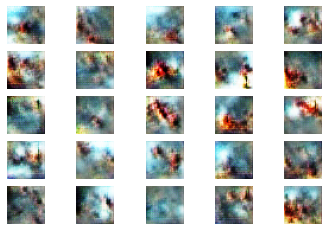

Epoch: 122, Discriminator loss mean:0.69605, Generator loss mean:0.71438
Epoch: 123, Discriminator loss mean:0.69493, Generator loss mean:0.71043
Epoch: 124, Discriminator loss mean:0.69660, Generator loss mean:0.71508
Epoch: 125, Discriminator loss mean:0.69510, Generator loss mean:0.70934
Epoch: 126, Discriminator loss mean:0.69553, Generator loss mean:0.70637
Epoch: 127, Discriminator loss mean:0.69563, Generator loss mean:0.70599
Epoch: 128, Discriminator loss mean:0.69665, Generator loss mean:0.70392
Epoch: 129, Discriminator loss mean:0.69617, Generator loss mean:0.71019
Epoch: 130, Discriminator loss mean:0.69587, Generator loss mean:0.70579
Epoch: 131, Discriminator loss mean:0.69313, Generator loss mean:0.70742


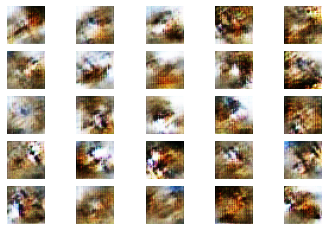

Epoch: 132, Discriminator loss mean:0.69732, Generator loss mean:0.71117
Epoch: 133, Discriminator loss mean:0.69687, Generator loss mean:0.70426
Epoch: 134, Discriminator loss mean:0.69591, Generator loss mean:0.70877
Epoch: 135, Discriminator loss mean:0.69606, Generator loss mean:0.71824
Epoch: 136, Discriminator loss mean:0.70254, Generator loss mean:0.71946
Epoch: 137, Discriminator loss mean:0.69597, Generator loss mean:0.70584
Epoch: 138, Discriminator loss mean:0.69338, Generator loss mean:0.70452
Epoch: 139, Discriminator loss mean:0.69863, Generator loss mean:0.71710
Epoch: 140, Discriminator loss mean:0.69991, Generator loss mean:0.71790
Epoch: 141, Discriminator loss mean:0.69499, Generator loss mean:0.70114


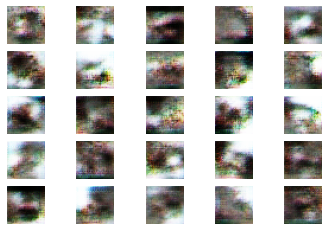

Epoch: 142, Discriminator loss mean:0.69745, Generator loss mean:0.70789
Epoch: 143, Discriminator loss mean:0.69410, Generator loss mean:0.71145
Epoch: 144, Discriminator loss mean:0.69707, Generator loss mean:0.71988
Epoch: 145, Discriminator loss mean:0.69677, Generator loss mean:0.71661
Epoch: 146, Discriminator loss mean:0.69708, Generator loss mean:0.71373
Epoch: 147, Discriminator loss mean:0.69517, Generator loss mean:0.71797
Epoch: 148, Discriminator loss mean:0.69703, Generator loss mean:0.70768
Epoch: 149, Discriminator loss mean:0.69491, Generator loss mean:0.72345
Epoch: 150, Discriminator loss mean:0.69685, Generator loss mean:0.70832
Epoch: 151, Discriminator loss mean:0.69476, Generator loss mean:0.70937


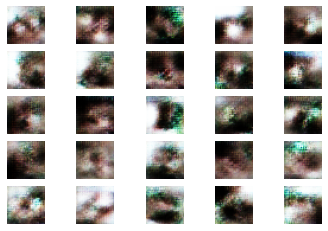

Epoch: 152, Discriminator loss mean:0.69537, Generator loss mean:0.71037
Epoch: 153, Discriminator loss mean:0.69799, Generator loss mean:0.72515
Epoch: 154, Discriminator loss mean:0.69909, Generator loss mean:0.70989
Epoch: 155, Discriminator loss mean:0.69454, Generator loss mean:0.71121
Epoch: 156, Discriminator loss mean:0.69441, Generator loss mean:0.71563
Epoch: 157, Discriminator loss mean:0.69433, Generator loss mean:0.70514
Epoch: 158, Discriminator loss mean:0.69730, Generator loss mean:0.71517
Epoch: 159, Discriminator loss mean:0.70017, Generator loss mean:0.71975
Epoch: 160, Discriminator loss mean:0.69774, Generator loss mean:0.71156
Epoch: 161, Discriminator loss mean:0.69598, Generator loss mean:0.71150


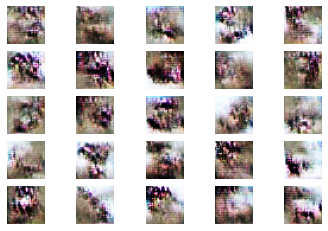

Epoch: 162, Discriminator loss mean:0.69669, Generator loss mean:0.70462
Epoch: 163, Discriminator loss mean:0.69589, Generator loss mean:0.70900
Epoch: 164, Discriminator loss mean:0.69569, Generator loss mean:0.71410
Epoch: 165, Discriminator loss mean:0.69498, Generator loss mean:0.70296
Epoch: 166, Discriminator loss mean:0.69788, Generator loss mean:0.71993
Epoch: 167, Discriminator loss mean:0.69577, Generator loss mean:0.71313
Epoch: 168, Discriminator loss mean:0.69582, Generator loss mean:0.71208
Epoch: 169, Discriminator loss mean:0.69652, Generator loss mean:0.71187
Epoch: 170, Discriminator loss mean:0.69481, Generator loss mean:0.70932
Epoch: 171, Discriminator loss mean:0.69487, Generator loss mean:0.71015


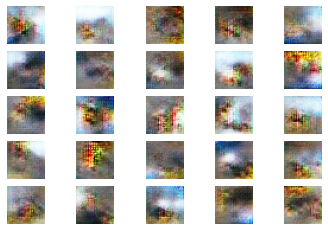

Epoch: 172, Discriminator loss mean:0.70094, Generator loss mean:0.72229
Epoch: 173, Discriminator loss mean:0.69572, Generator loss mean:0.70961
Epoch: 174, Discriminator loss mean:0.69514, Generator loss mean:0.71439
Epoch: 175, Discriminator loss mean:0.69624, Generator loss mean:0.71513
Epoch: 176, Discriminator loss mean:0.69746, Generator loss mean:0.70114
Epoch: 177, Discriminator loss mean:0.69602, Generator loss mean:0.70895
Epoch: 178, Discriminator loss mean:0.69595, Generator loss mean:0.71362
Epoch: 179, Discriminator loss mean:0.69654, Generator loss mean:0.71457
Epoch: 180, Discriminator loss mean:0.69280, Generator loss mean:0.70952
Epoch: 181, Discriminator loss mean:0.69527, Generator loss mean:0.71115


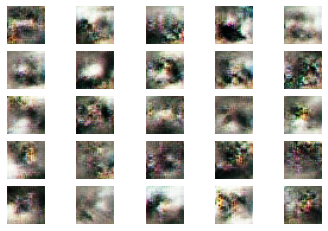

Epoch: 182, Discriminator loss mean:0.69776, Generator loss mean:0.70865
Epoch: 183, Discriminator loss mean:0.69611, Generator loss mean:0.70733
Epoch: 184, Discriminator loss mean:0.69604, Generator loss mean:0.70162
Epoch: 185, Discriminator loss mean:0.69781, Generator loss mean:0.71192
Epoch: 186, Discriminator loss mean:0.69394, Generator loss mean:0.70179
Epoch: 187, Discriminator loss mean:0.69523, Generator loss mean:0.70935
Epoch: 188, Discriminator loss mean:0.69745, Generator loss mean:0.70901
Epoch: 189, Discriminator loss mean:0.69640, Generator loss mean:0.72418
Epoch: 190, Discriminator loss mean:0.69915, Generator loss mean:0.69897
Epoch: 191, Discriminator loss mean:0.69422, Generator loss mean:0.70538


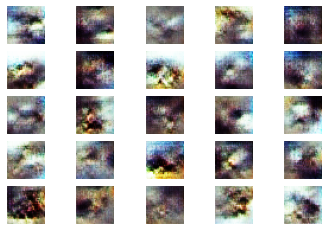

Epoch: 192, Discriminator loss mean:0.69490, Generator loss mean:0.71072
Epoch: 193, Discriminator loss mean:0.69716, Generator loss mean:0.71219
Epoch: 194, Discriminator loss mean:0.69580, Generator loss mean:0.70350
Epoch: 195, Discriminator loss mean:0.69541, Generator loss mean:0.71256
Epoch: 196, Discriminator loss mean:0.69407, Generator loss mean:0.70501
Epoch: 197, Discriminator loss mean:0.69607, Generator loss mean:0.70916
Epoch: 198, Discriminator loss mean:0.69747, Generator loss mean:0.70846
Epoch: 199, Discriminator loss mean:0.69518, Generator loss mean:0.70468
Epoch: 200, Discriminator loss mean:0.69539, Generator loss mean:0.69992
Epoch: 201, Discriminator loss mean:0.69590, Generator loss mean:0.70674


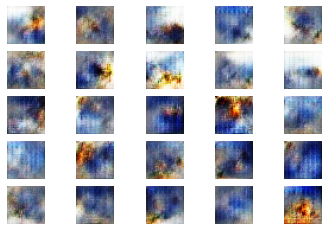

Epoch: 202, Discriminator loss mean:0.69525, Generator loss mean:0.70635
Epoch: 203, Discriminator loss mean:0.69514, Generator loss mean:0.70725
Epoch: 204, Discriminator loss mean:0.69530, Generator loss mean:0.71522
Epoch: 205, Discriminator loss mean:0.69606, Generator loss mean:0.71327
Epoch: 206, Discriminator loss mean:0.69595, Generator loss mean:0.72090
Epoch: 207, Discriminator loss mean:0.69664, Generator loss mean:0.70456
Epoch: 208, Discriminator loss mean:0.69650, Generator loss mean:0.70854
Epoch: 209, Discriminator loss mean:0.69648, Generator loss mean:0.70414
Epoch: 210, Discriminator loss mean:0.69504, Generator loss mean:0.70560
Epoch: 211, Discriminator loss mean:0.69365, Generator loss mean:0.71171


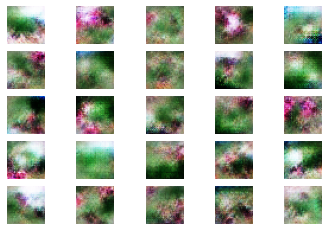

Epoch: 212, Discriminator loss mean:0.69833, Generator loss mean:0.71904
Epoch: 213, Discriminator loss mean:0.69625, Generator loss mean:0.71904
Epoch: 214, Discriminator loss mean:0.69383, Generator loss mean:0.71583
Epoch: 215, Discriminator loss mean:0.69768, Generator loss mean:0.70027
Epoch: 216, Discriminator loss mean:0.69952, Generator loss mean:0.71979
Epoch: 217, Discriminator loss mean:0.69726, Generator loss mean:0.70734
Epoch: 218, Discriminator loss mean:0.69647, Generator loss mean:0.70509
Epoch: 219, Discriminator loss mean:0.69747, Generator loss mean:0.71644
Epoch: 220, Discriminator loss mean:0.69537, Generator loss mean:0.70950
Epoch: 221, Discriminator loss mean:0.69661, Generator loss mean:0.70903


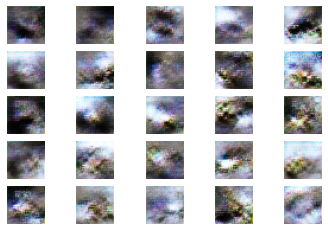

Epoch: 222, Discriminator loss mean:0.69782, Generator loss mean:0.70125
Epoch: 223, Discriminator loss mean:0.69746, Generator loss mean:0.70679
Epoch: 224, Discriminator loss mean:0.69684, Generator loss mean:0.70163
Epoch: 225, Discriminator loss mean:0.69321, Generator loss mean:0.70495
Epoch: 226, Discriminator loss mean:0.69718, Generator loss mean:0.70797
Epoch: 227, Discriminator loss mean:0.69900, Generator loss mean:0.71201
Epoch: 228, Discriminator loss mean:0.69513, Generator loss mean:0.69947
Epoch: 229, Discriminator loss mean:0.69533, Generator loss mean:0.70928
Epoch: 230, Discriminator loss mean:0.70192, Generator loss mean:0.69676
Epoch: 231, Discriminator loss mean:0.69575, Generator loss mean:0.70007


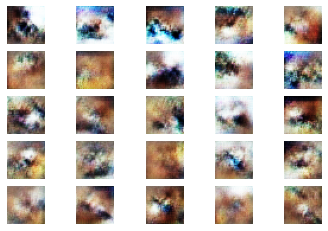

Epoch: 232, Discriminator loss mean:0.69672, Generator loss mean:0.70935
Epoch: 233, Discriminator loss mean:0.69538, Generator loss mean:0.70047
Epoch: 234, Discriminator loss mean:0.69391, Generator loss mean:0.70524
Epoch: 235, Discriminator loss mean:0.69619, Generator loss mean:0.70809
Epoch: 236, Discriminator loss mean:0.69515, Generator loss mean:0.70696
Epoch: 237, Discriminator loss mean:0.69603, Generator loss mean:0.70397
Epoch: 238, Discriminator loss mean:0.69734, Generator loss mean:0.70908
Epoch: 239, Discriminator loss mean:0.69586, Generator loss mean:0.71650
Epoch: 240, Discriminator loss mean:0.69929, Generator loss mean:0.71268
Epoch: 241, Discriminator loss mean:0.69727, Generator loss mean:0.69929


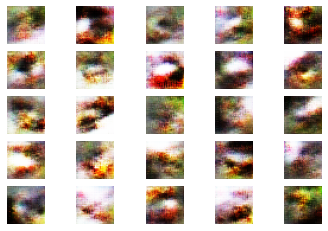

Epoch: 242, Discriminator loss mean:0.69426, Generator loss mean:0.70429
Epoch: 243, Discriminator loss mean:0.69549, Generator loss mean:0.70059
Epoch: 244, Discriminator loss mean:0.69531, Generator loss mean:0.70404
Epoch: 245, Discriminator loss mean:0.69523, Generator loss mean:0.70465
Epoch: 246, Discriminator loss mean:0.69589, Generator loss mean:0.71588
Epoch: 247, Discriminator loss mean:0.69645, Generator loss mean:0.71009
Epoch: 248, Discriminator loss mean:0.69521, Generator loss mean:0.70608
Epoch: 249, Discriminator loss mean:0.69459, Generator loss mean:0.70872
Epoch: 250, Discriminator loss mean:0.69501, Generator loss mean:0.69778
Epoch: 251, Discriminator loss mean:0.69732, Generator loss mean:0.71092


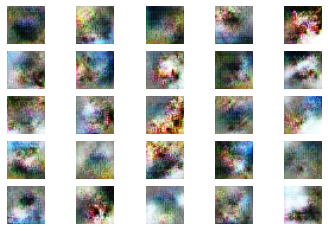

Epoch: 252, Discriminator loss mean:0.69616, Generator loss mean:0.70319
Epoch: 253, Discriminator loss mean:0.69467, Generator loss mean:0.70510
Epoch: 254, Discriminator loss mean:0.69437, Generator loss mean:0.70177
Epoch: 255, Discriminator loss mean:0.69611, Generator loss mean:0.70710
Epoch: 256, Discriminator loss mean:0.69735, Generator loss mean:0.71758
Epoch: 257, Discriminator loss mean:0.69542, Generator loss mean:0.69434
Epoch: 258, Discriminator loss mean:0.69498, Generator loss mean:0.70077
Epoch: 259, Discriminator loss mean:0.69461, Generator loss mean:0.71019
Epoch: 260, Discriminator loss mean:0.69473, Generator loss mean:0.70626
Epoch: 261, Discriminator loss mean:0.69393, Generator loss mean:0.70446


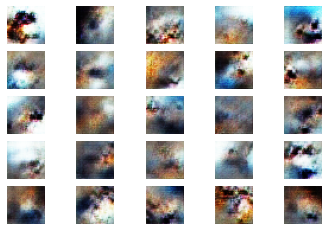

Epoch: 262, Discriminator loss mean:0.69587, Generator loss mean:0.69818
Epoch: 263, Discriminator loss mean:0.69454, Generator loss mean:0.70293
Epoch: 264, Discriminator loss mean:0.69466, Generator loss mean:0.70390
Epoch: 265, Discriminator loss mean:0.69452, Generator loss mean:0.70500
Epoch: 266, Discriminator loss mean:0.69692, Generator loss mean:0.70940
Epoch: 267, Discriminator loss mean:0.69505, Generator loss mean:0.70413
Epoch: 268, Discriminator loss mean:0.69531, Generator loss mean:0.70226
Epoch: 269, Discriminator loss mean:0.69621, Generator loss mean:0.70976
Epoch: 270, Discriminator loss mean:0.69489, Generator loss mean:0.70282
Epoch: 271, Discriminator loss mean:0.69562, Generator loss mean:0.70151


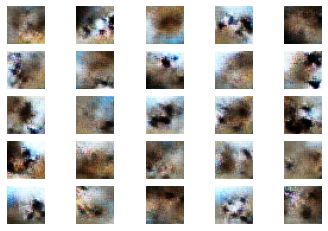

Epoch: 272, Discriminator loss mean:0.69380, Generator loss mean:0.70728
Epoch: 273, Discriminator loss mean:0.69614, Generator loss mean:0.70089
Epoch: 274, Discriminator loss mean:0.69498, Generator loss mean:0.70467
Epoch: 275, Discriminator loss mean:0.69541, Generator loss mean:0.70132
Epoch: 276, Discriminator loss mean:0.69582, Generator loss mean:0.70048
Epoch: 277, Discriminator loss mean:0.69465, Generator loss mean:0.69906
Epoch: 278, Discriminator loss mean:0.69436, Generator loss mean:0.70497
Epoch: 279, Discriminator loss mean:0.69693, Generator loss mean:0.70416
Epoch: 280, Discriminator loss mean:0.69479, Generator loss mean:0.70031
Epoch: 281, Discriminator loss mean:0.69459, Generator loss mean:0.69520


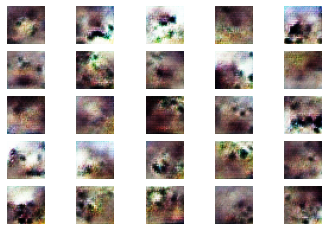

Epoch: 282, Discriminator loss mean:0.69437, Generator loss mean:0.70300
Epoch: 283, Discriminator loss mean:0.69590, Generator loss mean:0.70271
Epoch: 284, Discriminator loss mean:0.69553, Generator loss mean:0.70610
Epoch: 285, Discriminator loss mean:0.69538, Generator loss mean:0.69971
Epoch: 286, Discriminator loss mean:0.69462, Generator loss mean:0.69748
Epoch: 287, Discriminator loss mean:0.69444, Generator loss mean:0.69814
Epoch: 288, Discriminator loss mean:0.69436, Generator loss mean:0.70222
Epoch: 289, Discriminator loss mean:0.69444, Generator loss mean:0.69238
Epoch: 290, Discriminator loss mean:0.69573, Generator loss mean:0.70141
Epoch: 291, Discriminator loss mean:0.69496, Generator loss mean:0.69970


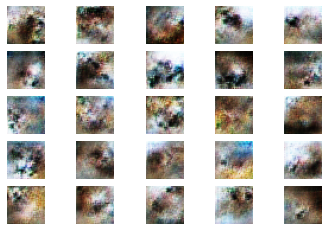

Epoch: 292, Discriminator loss mean:0.69520, Generator loss mean:0.69861
Epoch: 293, Discriminator loss mean:0.69498, Generator loss mean:0.70091
Epoch: 294, Discriminator loss mean:0.69439, Generator loss mean:0.69630
Epoch: 295, Discriminator loss mean:0.69471, Generator loss mean:0.69954
Epoch: 296, Discriminator loss mean:0.69502, Generator loss mean:0.70549
Epoch: 297, Discriminator loss mean:0.69355, Generator loss mean:0.69745
Epoch: 298, Discriminator loss mean:0.69523, Generator loss mean:0.70227
Epoch: 299, Discriminator loss mean:0.69479, Generator loss mean:0.69881
Epoch: 300, Discriminator loss mean:0.69486, Generator loss mean:0.69674
Epoch: 301, Discriminator loss mean:0.69448, Generator loss mean:0.69670


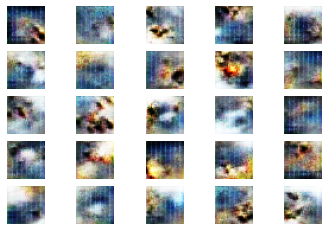

Epoch: 302, Discriminator loss mean:0.69445, Generator loss mean:0.69751
Epoch: 303, Discriminator loss mean:0.69456, Generator loss mean:0.70146
Epoch: 304, Discriminator loss mean:0.69465, Generator loss mean:0.70281
Epoch: 305, Discriminator loss mean:0.69447, Generator loss mean:0.69481
Epoch: 306, Discriminator loss mean:0.69442, Generator loss mean:0.70123
Epoch: 307, Discriminator loss mean:0.69536, Generator loss mean:0.69879
Epoch: 308, Discriminator loss mean:0.69493, Generator loss mean:0.70645
Epoch: 309, Discriminator loss mean:0.69545, Generator loss mean:0.70321
Epoch: 310, Discriminator loss mean:0.69594, Generator loss mean:0.70715
Epoch: 311, Discriminator loss mean:0.69701, Generator loss mean:0.70643


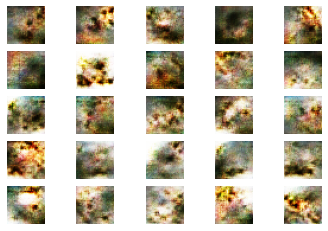

Epoch: 312, Discriminator loss mean:0.69482, Generator loss mean:0.69505
Epoch: 313, Discriminator loss mean:0.69480, Generator loss mean:0.70042
Epoch: 314, Discriminator loss mean:0.69426, Generator loss mean:0.69930
Epoch: 315, Discriminator loss mean:0.69453, Generator loss mean:0.69510
Epoch: 316, Discriminator loss mean:0.69412, Generator loss mean:0.69934
Epoch: 317, Discriminator loss mean:0.69390, Generator loss mean:0.69338
Epoch: 318, Discriminator loss mean:0.69464, Generator loss mean:0.70032
Epoch: 319, Discriminator loss mean:0.69461, Generator loss mean:0.70020
Epoch: 320, Discriminator loss mean:0.69486, Generator loss mean:0.69935
Epoch: 321, Discriminator loss mean:0.69449, Generator loss mean:0.69835


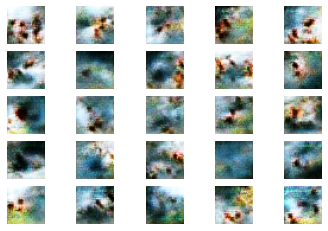

Epoch: 322, Discriminator loss mean:0.69446, Generator loss mean:0.69662
Epoch: 323, Discriminator loss mean:0.69415, Generator loss mean:0.69717
Epoch: 324, Discriminator loss mean:0.69445, Generator loss mean:0.69777
Epoch: 325, Discriminator loss mean:0.69475, Generator loss mean:0.69877
Epoch: 326, Discriminator loss mean:0.69485, Generator loss mean:0.70121
Epoch: 327, Discriminator loss mean:0.69453, Generator loss mean:0.70029
Epoch: 328, Discriminator loss mean:0.69442, Generator loss mean:0.69654
Epoch: 329, Discriminator loss mean:0.69417, Generator loss mean:0.69785
Epoch: 330, Discriminator loss mean:0.69446, Generator loss mean:0.69583
Epoch: 331, Discriminator loss mean:0.69457, Generator loss mean:0.69998


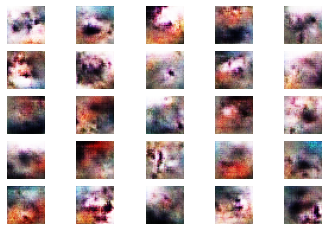

Epoch: 332, Discriminator loss mean:0.69446, Generator loss mean:0.69736
Epoch: 333, Discriminator loss mean:0.69469, Generator loss mean:0.69490
Epoch: 334, Discriminator loss mean:0.69471, Generator loss mean:0.70062
Epoch: 335, Discriminator loss mean:0.69419, Generator loss mean:0.69277
Epoch: 336, Discriminator loss mean:0.69406, Generator loss mean:0.69615
Epoch: 337, Discriminator loss mean:0.69435, Generator loss mean:0.69991
Epoch: 338, Discriminator loss mean:0.69393, Generator loss mean:0.69663
Epoch: 339, Discriminator loss mean:0.69523, Generator loss mean:0.69720
Epoch: 340, Discriminator loss mean:0.69412, Generator loss mean:0.69608
Epoch: 341, Discriminator loss mean:0.69410, Generator loss mean:0.69650


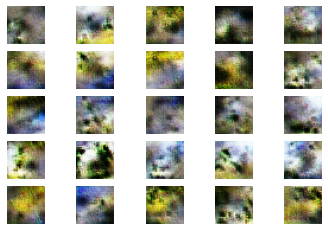

Epoch: 342, Discriminator loss mean:0.69421, Generator loss mean:0.69408
Epoch: 343, Discriminator loss mean:0.69399, Generator loss mean:0.69553
Epoch: 344, Discriminator loss mean:0.69439, Generator loss mean:0.69744
Epoch: 345, Discriminator loss mean:0.69448, Generator loss mean:0.69841
Epoch: 346, Discriminator loss mean:0.69431, Generator loss mean:0.69759
Epoch: 347, Discriminator loss mean:0.69448, Generator loss mean:0.69782
Epoch: 348, Discriminator loss mean:0.69497, Generator loss mean:0.70065
Epoch: 349, Discriminator loss mean:0.69471, Generator loss mean:0.69832
Epoch: 350, Discriminator loss mean:0.69499, Generator loss mean:0.70030
Epoch: 351, Discriminator loss mean:0.69410, Generator loss mean:0.69737


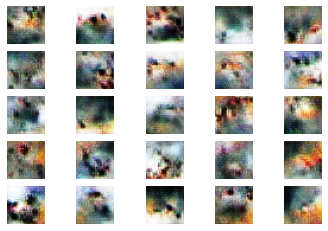

Epoch: 352, Discriminator loss mean:0.69414, Generator loss mean:0.69475
Epoch: 353, Discriminator loss mean:0.69434, Generator loss mean:0.70184
Epoch: 354, Discriminator loss mean:0.69478, Generator loss mean:0.69524
Epoch: 355, Discriminator loss mean:0.69483, Generator loss mean:0.69734
Epoch: 356, Discriminator loss mean:0.69419, Generator loss mean:0.69368
Epoch: 357, Discriminator loss mean:0.69404, Generator loss mean:0.69764
Epoch: 358, Discriminator loss mean:0.69401, Generator loss mean:0.69757
Epoch: 359, Discriminator loss mean:0.69552, Generator loss mean:0.70018
Epoch: 360, Discriminator loss mean:0.69506, Generator loss mean:0.69817
Epoch: 361, Discriminator loss mean:0.69393, Generator loss mean:0.69646


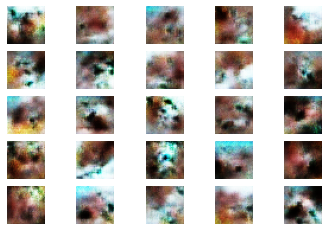

Epoch: 362, Discriminator loss mean:0.69412, Generator loss mean:0.69855
Epoch: 363, Discriminator loss mean:0.69527, Generator loss mean:0.69763
Epoch: 364, Discriminator loss mean:0.69404, Generator loss mean:0.69572
Epoch: 365, Discriminator loss mean:0.69423, Generator loss mean:0.69854
Epoch: 366, Discriminator loss mean:0.69394, Generator loss mean:0.69478
Epoch: 367, Discriminator loss mean:0.69406, Generator loss mean:0.69555
Epoch: 368, Discriminator loss mean:0.69397, Generator loss mean:0.69687
Epoch: 369, Discriminator loss mean:0.69431, Generator loss mean:0.69607
Epoch: 370, Discriminator loss mean:0.69431, Generator loss mean:0.69536
Epoch: 371, Discriminator loss mean:0.69415, Generator loss mean:0.69660


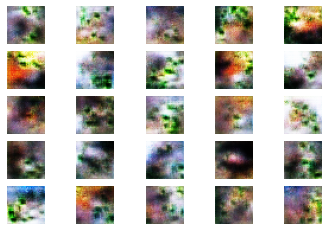

Epoch: 372, Discriminator loss mean:0.69424, Generator loss mean:0.69559
Epoch: 373, Discriminator loss mean:0.69428, Generator loss mean:0.69856
Epoch: 374, Discriminator loss mean:0.69392, Generator loss mean:0.69416
Epoch: 375, Discriminator loss mean:0.69401, Generator loss mean:0.69789
Epoch: 376, Discriminator loss mean:0.69414, Generator loss mean:0.69615
Epoch: 377, Discriminator loss mean:0.69392, Generator loss mean:0.69503
Epoch: 378, Discriminator loss mean:0.69434, Generator loss mean:0.69654
Epoch: 379, Discriminator loss mean:0.69387, Generator loss mean:0.69512
Epoch: 380, Discriminator loss mean:0.69420, Generator loss mean:0.69707
Epoch: 381, Discriminator loss mean:0.69430, Generator loss mean:0.69663


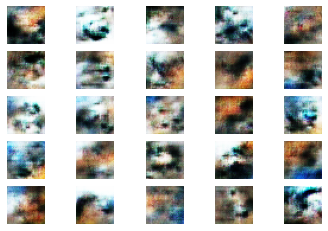

Epoch: 382, Discriminator loss mean:0.69418, Generator loss mean:0.69686
Epoch: 383, Discriminator loss mean:0.69420, Generator loss mean:0.69672
Epoch: 384, Discriminator loss mean:0.69387, Generator loss mean:0.69484
Epoch: 385, Discriminator loss mean:0.69446, Generator loss mean:0.69754
Epoch: 386, Discriminator loss mean:0.69429, Generator loss mean:0.69722
Epoch: 387, Discriminator loss mean:0.69463, Generator loss mean:0.69666
Epoch: 388, Discriminator loss mean:0.69422, Generator loss mean:0.69629
Epoch: 389, Discriminator loss mean:0.69423, Generator loss mean:0.69810
Epoch: 390, Discriminator loss mean:0.69453, Generator loss mean:0.69603
Epoch: 391, Discriminator loss mean:0.69464, Generator loss mean:0.69665


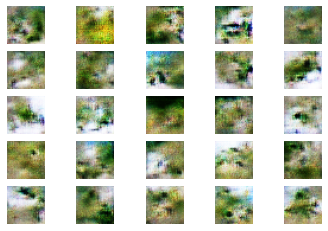

Epoch: 392, Discriminator loss mean:0.69398, Generator loss mean:0.69607
Epoch: 393, Discriminator loss mean:0.69424, Generator loss mean:0.69604
Epoch: 394, Discriminator loss mean:0.69388, Generator loss mean:0.69471
Epoch: 395, Discriminator loss mean:0.69427, Generator loss mean:0.69704
Epoch: 396, Discriminator loss mean:0.69450, Generator loss mean:0.69775
Epoch: 397, Discriminator loss mean:0.69386, Generator loss mean:0.69423
Epoch: 398, Discriminator loss mean:0.69366, Generator loss mean:0.69365
Epoch: 399, Discriminator loss mean:0.69418, Generator loss mean:0.69982
Epoch: 400, Discriminator loss mean:0.69430, Generator loss mean:0.69551
Epoch: 401, Discriminator loss mean:0.69424, Generator loss mean:0.69538


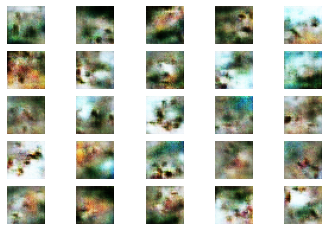

Epoch: 402, Discriminator loss mean:0.69426, Generator loss mean:0.69904
Epoch: 403, Discriminator loss mean:0.69436, Generator loss mean:0.69683
Epoch: 404, Discriminator loss mean:0.69476, Generator loss mean:0.69774
Epoch: 405, Discriminator loss mean:0.69439, Generator loss mean:0.69793
Epoch: 406, Discriminator loss mean:0.69455, Generator loss mean:0.69815
Epoch: 407, Discriminator loss mean:0.69437, Generator loss mean:0.69712
Epoch: 408, Discriminator loss mean:0.69423, Generator loss mean:0.69351
Epoch: 409, Discriminator loss mean:0.69430, Generator loss mean:0.69698
Epoch: 410, Discriminator loss mean:0.69396, Generator loss mean:0.69737
Epoch: 411, Discriminator loss mean:0.69397, Generator loss mean:0.69352


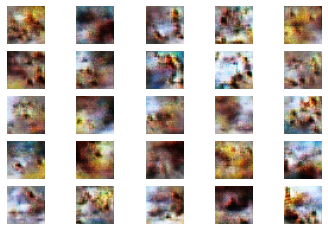

Epoch: 412, Discriminator loss mean:0.69423, Generator loss mean:0.69708
Epoch: 413, Discriminator loss mean:0.69415, Generator loss mean:0.69697
Epoch: 414, Discriminator loss mean:0.69418, Generator loss mean:0.69444
Epoch: 415, Discriminator loss mean:0.69395, Generator loss mean:0.69660
Epoch: 416, Discriminator loss mean:0.69439, Generator loss mean:0.69582
Epoch: 417, Discriminator loss mean:0.69500, Generator loss mean:0.69659
Epoch: 418, Discriminator loss mean:0.69453, Generator loss mean:0.69669
Epoch: 419, Discriminator loss mean:0.69418, Generator loss mean:0.69712
Epoch: 420, Discriminator loss mean:0.69415, Generator loss mean:0.69488
Epoch: 421, Discriminator loss mean:0.69426, Generator loss mean:0.69567


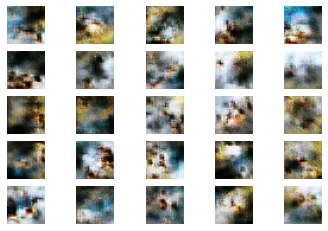

Epoch: 422, Discriminator loss mean:0.69399, Generator loss mean:0.69371
Epoch: 423, Discriminator loss mean:0.69379, Generator loss mean:0.69533
Epoch: 424, Discriminator loss mean:0.69435, Generator loss mean:0.69588
Epoch: 425, Discriminator loss mean:0.69399, Generator loss mean:0.69470
Epoch: 426, Discriminator loss mean:0.69410, Generator loss mean:0.69672
Epoch: 427, Discriminator loss mean:0.69425, Generator loss mean:0.69688
Epoch: 428, Discriminator loss mean:0.69410, Generator loss mean:0.69631
Epoch: 429, Discriminator loss mean:0.69418, Generator loss mean:0.69703
Epoch: 430, Discriminator loss mean:0.69385, Generator loss mean:0.69372
Epoch: 431, Discriminator loss mean:0.69440, Generator loss mean:0.69646


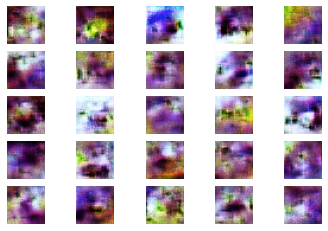

Epoch: 432, Discriminator loss mean:0.69417, Generator loss mean:0.69456
Epoch: 433, Discriminator loss mean:0.69402, Generator loss mean:0.69517
Epoch: 434, Discriminator loss mean:0.69409, Generator loss mean:0.69786
Epoch: 435, Discriminator loss mean:0.69405, Generator loss mean:0.69225
Epoch: 436, Discriminator loss mean:0.69395, Generator loss mean:0.69566
Epoch: 437, Discriminator loss mean:0.69421, Generator loss mean:0.69581
Epoch: 438, Discriminator loss mean:0.69390, Generator loss mean:0.69597
Epoch: 439, Discriminator loss mean:0.69385, Generator loss mean:0.69517
Epoch: 440, Discriminator loss mean:0.69418, Generator loss mean:0.69628
Epoch: 441, Discriminator loss mean:0.69419, Generator loss mean:0.69595


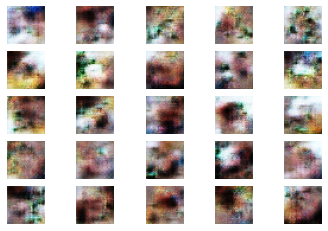

Epoch: 442, Discriminator loss mean:0.69421, Generator loss mean:0.69789
Epoch: 443, Discriminator loss mean:0.69424, Generator loss mean:0.69567
Epoch: 444, Discriminator loss mean:0.69460, Generator loss mean:0.69858
Epoch: 445, Discriminator loss mean:0.69405, Generator loss mean:0.69365
Epoch: 446, Discriminator loss mean:0.69404, Generator loss mean:0.69735
Epoch: 447, Discriminator loss mean:0.69385, Generator loss mean:0.69439
Epoch: 448, Discriminator loss mean:0.69449, Generator loss mean:0.69670
Epoch: 449, Discriminator loss mean:0.69393, Generator loss mean:0.69565
Epoch: 450, Discriminator loss mean:0.69458, Generator loss mean:0.69698
Epoch: 451, Discriminator loss mean:0.69406, Generator loss mean:0.69688


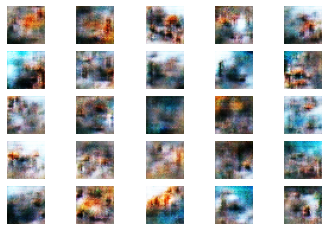

Epoch: 452, Discriminator loss mean:0.69391, Generator loss mean:0.69181
Epoch: 453, Discriminator loss mean:0.69396, Generator loss mean:0.69712
Epoch: 454, Discriminator loss mean:0.69416, Generator loss mean:0.69458
Epoch: 455, Discriminator loss mean:0.69404, Generator loss mean:0.69485
Epoch: 456, Discriminator loss mean:0.69429, Generator loss mean:0.69617
Epoch: 457, Discriminator loss mean:0.69424, Generator loss mean:0.69520
Epoch: 458, Discriminator loss mean:0.69400, Generator loss mean:0.69525
Epoch: 459, Discriminator loss mean:0.69381, Generator loss mean:0.69723
Epoch: 460, Discriminator loss mean:0.69451, Generator loss mean:0.69480
Epoch: 461, Discriminator loss mean:0.69433, Generator loss mean:0.69620


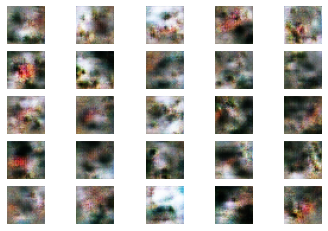

Epoch: 462, Discriminator loss mean:0.69384, Generator loss mean:0.69696
Epoch: 463, Discriminator loss mean:0.69451, Generator loss mean:0.69658
Epoch: 464, Discriminator loss mean:0.69450, Generator loss mean:0.69856
Epoch: 465, Discriminator loss mean:0.69453, Generator loss mean:0.69432
Epoch: 466, Discriminator loss mean:0.69474, Generator loss mean:0.69746
Epoch: 467, Discriminator loss mean:0.69445, Generator loss mean:0.69666
Epoch: 468, Discriminator loss mean:0.69469, Generator loss mean:0.69659
Epoch: 469, Discriminator loss mean:0.69374, Generator loss mean:0.69448
Epoch: 470, Discriminator loss mean:0.69477, Generator loss mean:0.69686
Epoch: 471, Discriminator loss mean:0.69450, Generator loss mean:0.69766


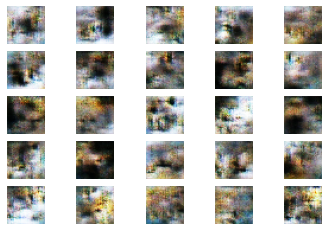

Epoch: 472, Discriminator loss mean:0.69438, Generator loss mean:0.69558
Epoch: 473, Discriminator loss mean:0.69416, Generator loss mean:0.69827
Epoch: 474, Discriminator loss mean:0.69411, Generator loss mean:0.69529
Epoch: 475, Discriminator loss mean:0.69415, Generator loss mean:0.69370
Epoch: 476, Discriminator loss mean:0.69389, Generator loss mean:0.69700
Epoch: 477, Discriminator loss mean:0.69459, Generator loss mean:0.69540
Epoch: 478, Discriminator loss mean:0.69437, Generator loss mean:0.69682
Epoch: 479, Discriminator loss mean:0.69455, Generator loss mean:0.69477
Epoch: 480, Discriminator loss mean:0.69404, Generator loss mean:0.69591
Epoch: 481, Discriminator loss mean:0.69396, Generator loss mean:0.69496


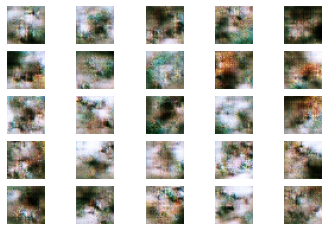

Epoch: 482, Discriminator loss mean:0.69423, Generator loss mean:0.69754
Epoch: 483, Discriminator loss mean:0.69456, Generator loss mean:0.69467
Epoch: 484, Discriminator loss mean:0.69426, Generator loss mean:0.69802
Epoch: 485, Discriminator loss mean:0.69395, Generator loss mean:0.69499
Epoch: 486, Discriminator loss mean:0.69390, Generator loss mean:0.69657
Epoch: 487, Discriminator loss mean:0.69407, Generator loss mean:0.69519
Epoch: 488, Discriminator loss mean:0.69403, Generator loss mean:0.69644
Epoch: 489, Discriminator loss mean:0.69415, Generator loss mean:0.69372
Epoch: 490, Discriminator loss mean:0.69413, Generator loss mean:0.69678
Epoch: 491, Discriminator loss mean:0.69406, Generator loss mean:0.69797


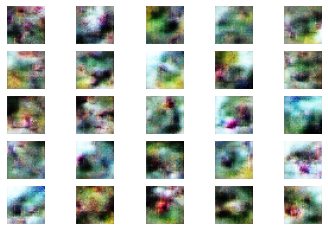

Epoch: 492, Discriminator loss mean:0.69400, Generator loss mean:0.69527
Epoch: 493, Discriminator loss mean:0.69458, Generator loss mean:0.69673
Epoch: 494, Discriminator loss mean:0.69373, Generator loss mean:0.69506
Epoch: 495, Discriminator loss mean:0.69412, Generator loss mean:0.69574
Epoch: 496, Discriminator loss mean:0.69390, Generator loss mean:0.69566
Epoch: 497, Discriminator loss mean:0.69418, Generator loss mean:0.69656
Epoch: 498, Discriminator loss mean:0.69379, Generator loss mean:0.69517
Epoch: 499, Discriminator loss mean:0.69406, Generator loss mean:0.69488
Epoch: 500, Discriminator loss mean:0.69435, Generator loss mean:0.69696


In [16]:
train(gan,generator,discriminator,X)

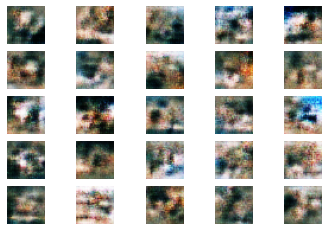

In [25]:
#Iter 3, after 100 epochs
plot_generated_images(generator,100,25)

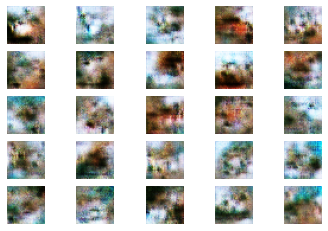

In [19]:
#Iter 3, after 500 epochs
plot_generated_images(generator,300,25)

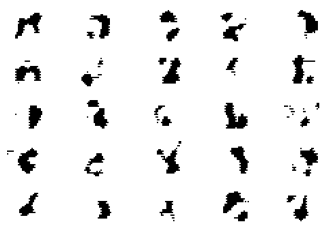

In [22]:
#Iter 2, after 40 epochs, generator loss is 0.06308
plot_generated_images(generator,100,25)